# A linear model

- Author: [givasile](https://givasile.github.io/)
- Date created: 2024/04/29
- Last modified: 2025/03/24
- **Description**: Apply all global effect methods on a linear model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/givasile/effector/blob/main/notebooks/synthetic-examples/01_linear_model.ipynb) 

[![Open in GitHub](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/givasile/effector/blob/main/notebooks/synthetic-examples/01_linear_model.ipynb)

In [31]:
import numpy as np
import effector

## Global Effect Methods in a Linear Model  

Global effect is the **average** impact of a feature $x_s$ on the model’s output $y$.

Global effect methods (a) first compute the local (instance-level) effects, the effects of $x_s$ on the model’s output $y$ for each particular instance $\mathbf{x}^i$ (local effect) and (b) then average them to produce the global effect.

Typically, in real-life ML models, the output $y$ depends on all feature values simultaneously, 
In these cases, the instance-level effects deviate from the **average** effect. 
In these cases, **heterogeneity** helps quantify the extent of such deviation from the average.  

However, in a linear model $f(\mathbf{x}) = \sum_{i=1}^D a_i x_i$ the effect of each feature is simply $ a_i x_i $ with **zero heterogeneity**.  

In this tutorial, we confirm that all feature effect methods in `effector` agree on this result.  

## Global Effect Methods in a Linear Model

The **global effect** of a feature $x_s$ is its **average** impact on the model’s output $y$. Global effect methods work in two steps:

1. Compute one **local effect** per dataset instance $\mathbf{x}^i$, which shows how $x_s$ influences $y$ for instance $i$
2. Average these local effects to get the **global effect**

In typical ML models, the effect of $x_s$ on $y$ depends the value of the other features.
This causes an increase in the **heterogeneity**, i.e., the quantity that measures how much local effects deviate from the average.

For a **linear model**, however, it holds that:  

$$
f(\mathbf{x}) = \sum_{i=1}^D a_i x_i
$$

Therefore, the effect of each feature is simply $a_i x_i$, with **zero heterogeneity**.
In this tutorial, we verify that all feature effect methods in `effector` correctly reflect this result.


## Dataset and Model

As a black-box function, we will use a linear model: $y = 7x_1 - 3x_2 + 4x_3$
As dataset, we will generate $N=1000$ examples comming from the following distribution:

| Feature | Description                                                      | Distribution                      |
|---------|------------------------------------------------------------------|-----------------------------------|
| $x_1$   | Uniformly distributed between $0$ and $1$                        | $x_1 \sim \mathcal{U}(0,1)$       |
| $x_2$   | Follows $x_1$ with some added noise                              | $x_2 = x_1 + \epsilon, \epsilon \sim \mathcal{N}(0, 0.1)$ |
| $x_3$   | Uniformly distributed between $0$ and $1$                        | $x_3 \sim \mathcal{U}(0,1)$       |

In [32]:
def generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma):
    x1 = np.random.uniform(x1_min, x1_max, size=int(N))
    x2 = np.random.normal(loc=x1, scale=x2_sigma)
    x3 = np.random.uniform(x1_min, x1_max, size=int(N))
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset
np.random.seed(21)

N = 1000
x1_min = 0
x1_max = 1
x2_sigma = .1
x3_sigma = 1.
X = generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma)

In [33]:
def predict(x):
    y = 7*x[:, 0] - 3*x[:, 1] + 4*x[:, 2]
    return y

def predict_grad(x):
    df_dx1 = 7 * np.ones([x.shape[0]])
    df_dx2 = -3 * np.ones([x.shape[0]])
    df_dx3 = 4 * np.ones([x.shape[0]])
    return np.stack([df_dx1, df_dx2, df_dx3], axis=-1)

## Partial Dependence Plot (PDP)

The PDP is defined as **_the average prediction over the entire dataset when setting the feature of interest at a specific value._**
For example, the effect of the $s$-th feature at values $x_s$ is:

$$ \text{PDP}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c) $$

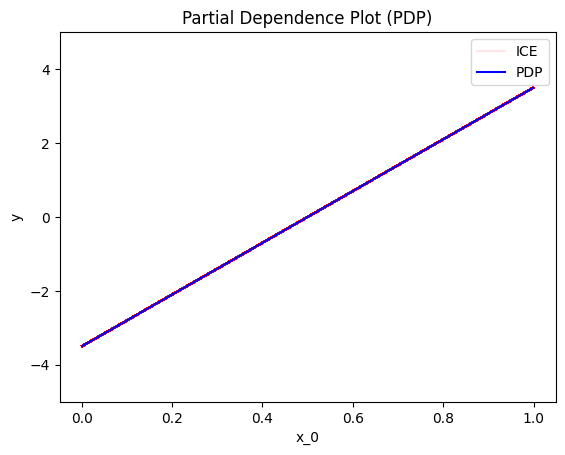

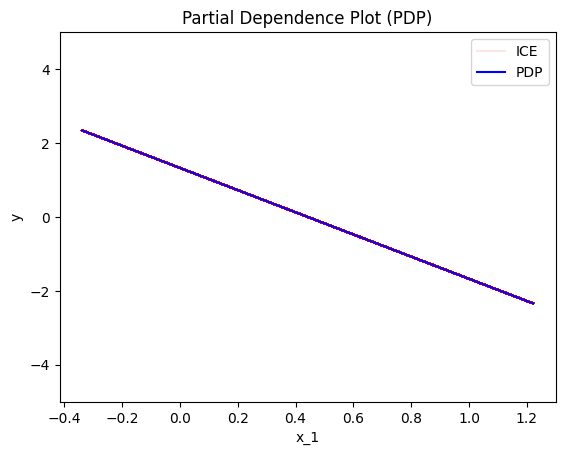

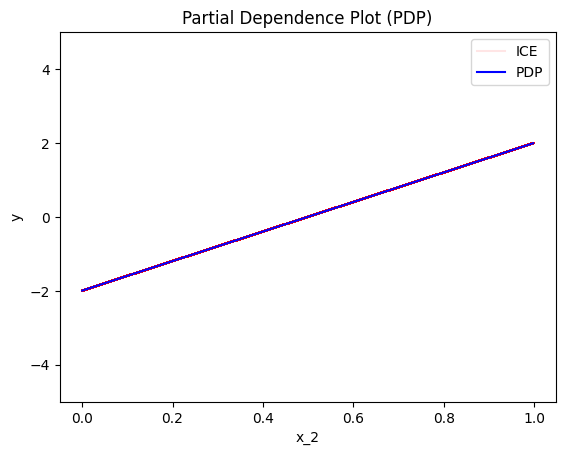

[None, None, None]

In [34]:
[effector.PDP(data=X, model=predict).plot(feature=i, y_limits=[-5,5]) for i in [0, 1, 2]]

As we expected, all feature effects are linear. Looking closer, we can also confirm the gradients of the effects: 
$7$ for $x_1$, $-3$ for $x_2$ and $4$ for $x_3$.

## Derivative-PDP (d-PDP)  

This method analyzes the model’s **derivative** to compute global effects:  

$$ \text{d-PDP}(x_s) = \frac{1}{N} \sum_{j=1}^N \frac{\partial f}{\partial x_s} (x_s, \mathbf{x}_c^{(i)}) $$

Since this is based on model derivatives, the expected effects are simply the gradients: **7** for $x_1$, **-3** for $x_2$ and **4** for $x_3$.


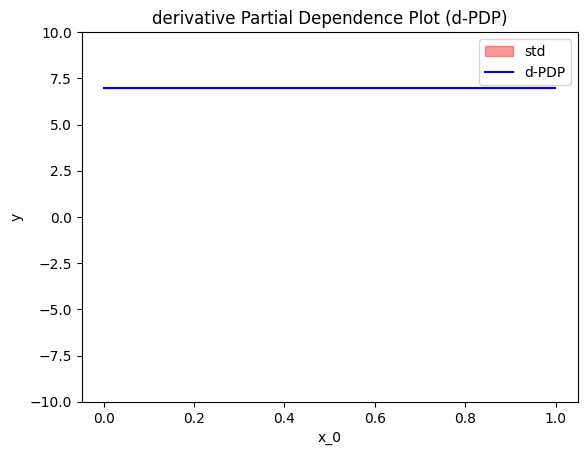

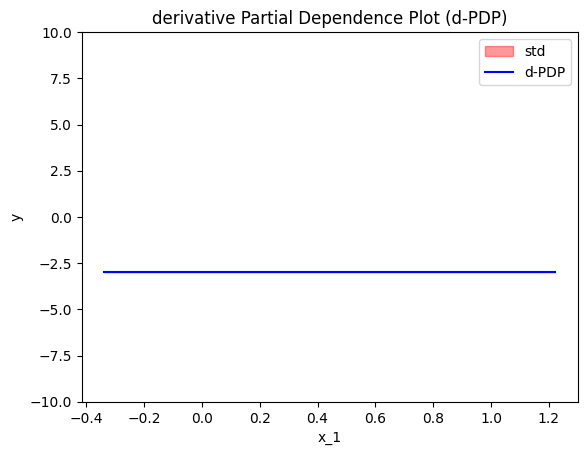

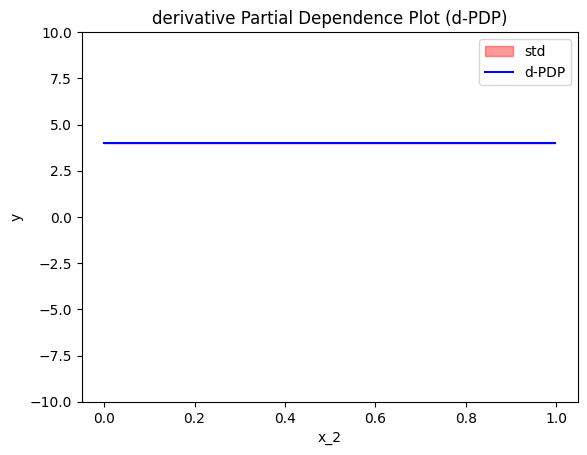

[None, None, None]

In [35]:
[effector.DerPDP(data=X, model=predict, model_jac=predict_grad).plot(feature=i, heterogeneity=True, dy_limits=[-10, 10]) for i in range(3)]

We have to mention that:
 
* d-PDP needs the model's gradient, which is not always available.
* The interpretation is given in the gradient-space, so it should be treated differently. In d-PDP the plots show how much the model's prediction *changes* given a change in the feature of interest. This is different from PDP, where the plots says how much the specific feature *contributes* to the prediction. 
* d-PDP is the gradient of the PDP, i.e., $\text{d-PDP}(x) = \frac{\partial \text{PDP}}{\partial x_s} (x)$
* d-ICE is the gradient of the ICE, i.e., $\text{d-ICE}^{(i)}(x) = \frac{\partial \text{ICE}^{(i)}}{\partial x_s} (x)$

## Accumulated Local Effects (ALE)

The next major category of feature effect techniques is [Accumulated Local Effects (ALE)](https://christophm.github.io/interpretable-ml-book/ale.html).


$$\text{ALE}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ f(z_k, x_c) - f(z_{k-1}, x_c) \right ]$$

where $k_{x_s}$ the index of the bin such that $z_{k_{x−1}} ≤ x_s < z_{k_x}$, $\mathcal{S}_k$ is the set of the instances lying at the $k$-th bin, i.e., $\mathcal{S}_k = \{ x^{(i)} : z_{k−1} \neq x^{(i)}_s < z_k \}$ and $\Delta x = \frac{x_{s, max} - x_{s, min}}{K}$.

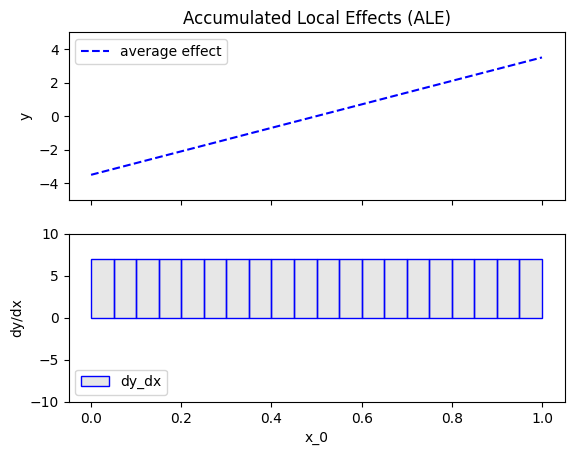

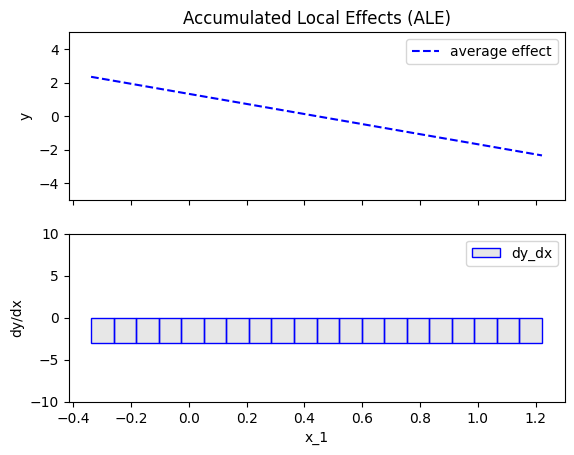

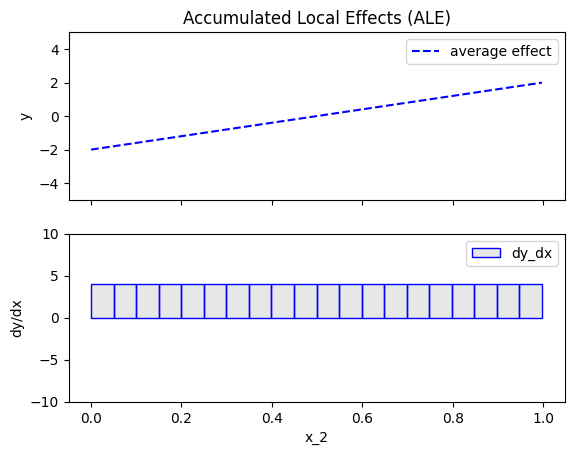

[None, None, None]

In [36]:
[effector.ALE(data=X, model=predict).plot(feature=i, y_limits=[-5,5], dy_limits=[-10, 10]) for i in range(3)]

## Robust and Heterogeneity-aware ALE (RHALE)

Robust and Heterogeneity-aware ALE (RHALE) is a variant of ALE, proposed by [Gkolemis et. al](https://arxiv.org/abs/2309.11193), which uses an automated variable-size binning splitting, to ensure robustness. Let's see how it works in practice.

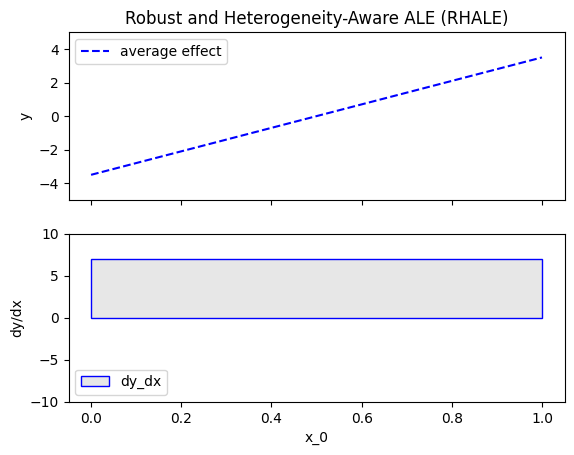

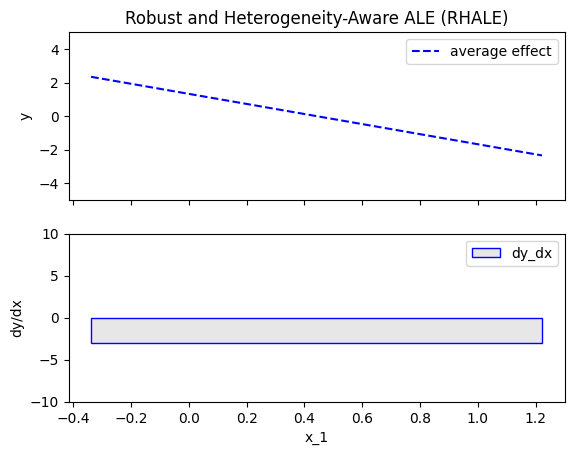

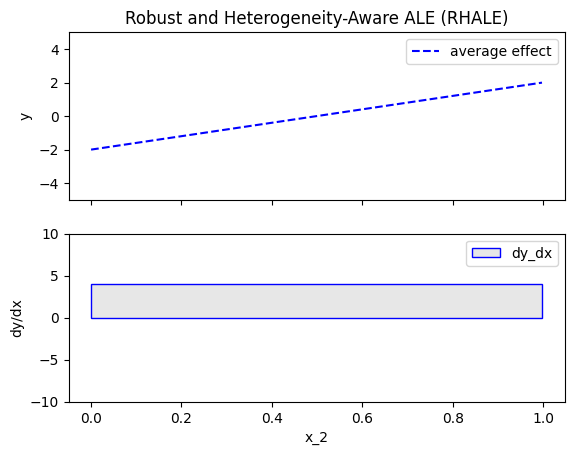

[None, None, None]

In [37]:
[effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=i, y_limits=[-5,5], dy_limits=[-10, 10]) for i in range(3)]

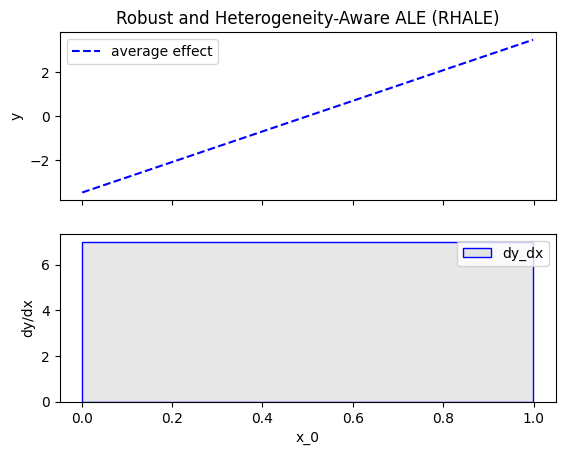

In [38]:
effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False)

## SHAP Dependence Plot

TODO add intro

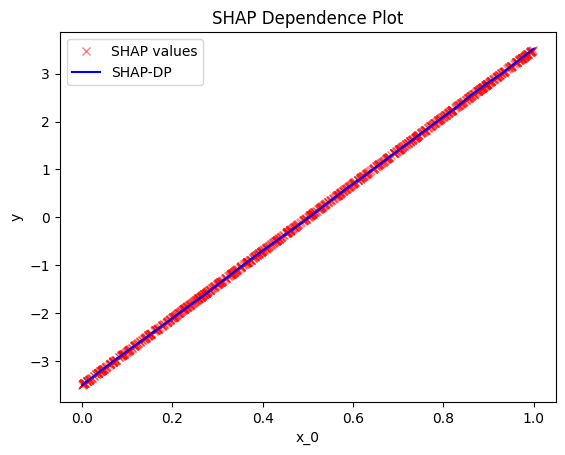

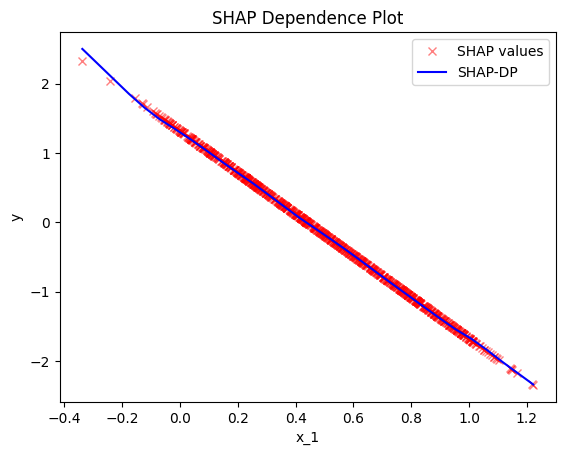

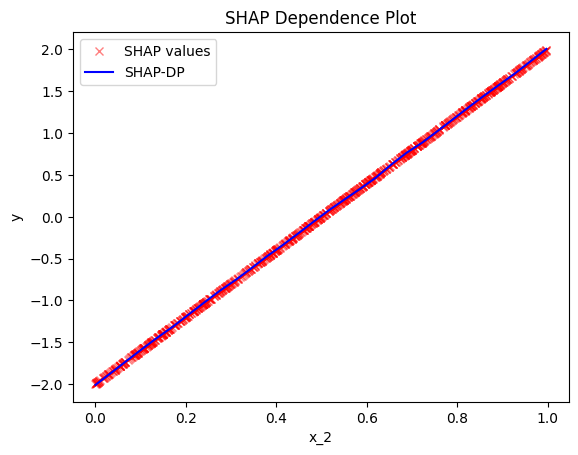

[None, None, None]

In [39]:
[effector.ShapDP(data=X, model=predict).plot(feature=i) for i in range(3)]

## Conclusion

In this tutorial, we introduced the various feature effect methods of `Effector` and used them to explain a linear model. 
As expected all methods "agree" for a linear model $f(\mathbf{x}) = \sum_{i=1}^D a_i x_i$, the effect of each feature is always $ a_i x_i $ with **zero heterogeneity**.  